# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Turn off the warnings
warnings.filterwarnings('ignore')

# Set the style to "darkgrid"
sns.set_style('darkgrid')

# Set the plt style to "ggplot"
plt.style.use('ggplot')

# Load the DataFrame from the pickle file
df = pd.read_pickle('data/netflixmoviemain_df.pkl')

# Replace 'None' with False for the 'is_nflx_original' column
df['is_nflx_original'] = df['is_nflx_original'].fillna(False)

## Field Descriptions
- `country`: The country of the movie's release.
- `jw_entity_id`: A unique identifier for the movie.
- `is_nflx_original`: Whether the movie is a Netflix original, with None values indicating missing data.
- `score`: A numerical score for the movie.
- `date`: The date related to the movie, likely the release date on the platform.
- `age_certification`: The age certification of the movie.
- `object_type`: The type of object, which is movie for all the displayed rows.
- `original_release_year`: The year the movie was originally released.
- `original_title`: The original title of the movie.
- `runtime`: The runtime of the movie in minutes.
- `seasons`: Number of seasons, probably irrelevant for movies as this seems like a TV show related column.
- `title`: The title of the movie.
- `genre`: The genre of the movie, with multiple columns from genre_1 to genre_12 indicating multiple genre classifications.

## Numerical Features:

- `rank`: Available for 2,475 movies with values ranging from 1 to 10, suggesting a top-10 ranking system.
- `score`: Present for all movies with a mean around 5.59 but a high standard deviation, indicating a wide distribution of scores. However, the maximum score is quite high at 759, suggesting outliers or a different scoring system for some entries.
- `original_release_year`: All movies have a release year, ranging from 1927 to 2022, with a median release year of 2014.
- `runtime`: Runtimes range from 10 to 339 minutes, with a median of 105 minutes.

In [2]:
# Descriptive statistics for numerical features
df.describe()

,rank,score,original_release_year,runtime,localized_release_date
count,2475.00000,25836.000000,25836.000000,25836.000000,6514
mean,6.01697,5.587823,2011.714236,106.523301,2021-07-05 17:28:16.653362176
min,1.00000,1.000000,1927.000000,10.000000,1986-10-01 00:00:00
25%,4.00000,1.000000,2007.000000,92.000000,2021-07-02 00:00:00
50%,6.00000,1.000000,2014.000000,105.000000,2021-12-24 00:00:00
75%,9.00000,1.000000,2020.000000,121.000000,2022-04-27 00:00:00
max,10.00000,759.000000,2022.000000,339.000000,2022-11-04 00:00:00
std,2.89909,25.357323,11.150207,27.355670,NaN


## Categorical Features:

- `country`: The dataset includes 37 unique countries with the most entries from Peru.
- `jw_entity_id`: There are 4,130 unique movie identifiers, with some movies appearing multiple times, possibly due to being listed under multiple countries.
- `is_nflx_original`: Only two unique values, true or false, indicating whether a movie is a Netflix original.
- `age_certification`: Five unique certifications are present, with 'R' being the most common.
- `original_title`: There are 4,097 unique titles, suggesting some titles are repeated, likely due to different entries for different countries or multiple entries over time.
- `production_countries`: There are 506 unique combinations of production countries, with the United States being the most common.

In [3]:
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns].describe()

,country,jw_entity_id,date,age_certification,object_type,original_title,production_countries,short_description,title,genres,...,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12
count,25836,25836,25836,16486,25836,25836,25836,25796,25836,25836,...,14372,7250,2942,930,369,100,24,8,8,8
unique,37,4130,1055,5,1,4097,506,4123,4090,1549,...,19,18,18,16,15,8,4,1,1,1
top,Peru,tm1227918,2022-09-01,R,movie,The Mummy,['US'],"A year after their romance began in Riccione, ...",The Mummy,['drama'],...,drama,drama,european,european,romance,sport,european,fantasy,animation,romance
freq,1222,35,1036,6701,25836,41,10157,35,41,1231,...,2590,1084,351,185,62,20,11,8,8,8


# Define functions for analysis

In [4]:
def compare_originals_by_country(df, country_name):
    country_df = df[df['country'] == country_name]
    originals_comparison = country_df.groupby('is_nflx_original')['score'].agg(['sum', 'mean', 'count']).reset_index()
    originals_comparison.rename(columns={'is_nflx_original': 'Netflix Original', 'sum': 'Total Score', 'mean': 'Average Score', 'count': 'Movie Count'}, inplace=True)
    originals_comparison['Netflix Original'] = originals_comparison['Netflix Original'].map({True: 'Original', False: 'Non-Original'})
    originals_comparison['Country'] = country_name
    return originals_comparison

def aggregate_scores_by_genre(df, country_name):
    genre_scores = pd.DataFrame(columns=['Genre', 'Total Score', 'Average Score', 'Country'])
    genre_columns = [col for col in df.columns if 'genre' in col]
    for column in genre_columns:
        if df[column].isna().all(): continue
        genre_score_sum = df.groupby(column)['score'].sum().sort_values(ascending=False)
        genre_score_avg = df.groupby(column)['score'].mean().sort_values(ascending=False)
        for genre in genre_score_sum.index:
            # Use the 'concat' method instead of 'append' which has been deprecated
            genre_scores = pd.concat([genre_scores, pd.DataFrame({'Genre': genre, 'Total Score': genre_score_sum[genre], 'Average Score': genre_score_avg[genre], 'Country': country_name}, index=[0])], ignore_index=True)
    return genre_scores

# Distribution of the 'score' column
The distribution of scores shows a highly skewed pattern, with most scores clustering at the lower end and a long tail extending towards higher values, which indicates the presence of outliers. The boxplot reveals these outliers beyond the upper whisker.

The high-score outliers, defined as those above the 99.5th percentile, have scores ranging from 173 to 759. The mean score among these outliers is approximately 263.6, with a standard deviation of about 120. The majority of these outliers have been released relatively recently, with a mean release year of 2018.

The scores are discrete and varied among the outliers, with several scores like 222 appearing 4 times, and others like 189, 186, and 202 appearing 3 times each. There are 93 unique high scores within the outlier range, indicating these aren't just one-off anomalies but rather a consistent pattern of high scores

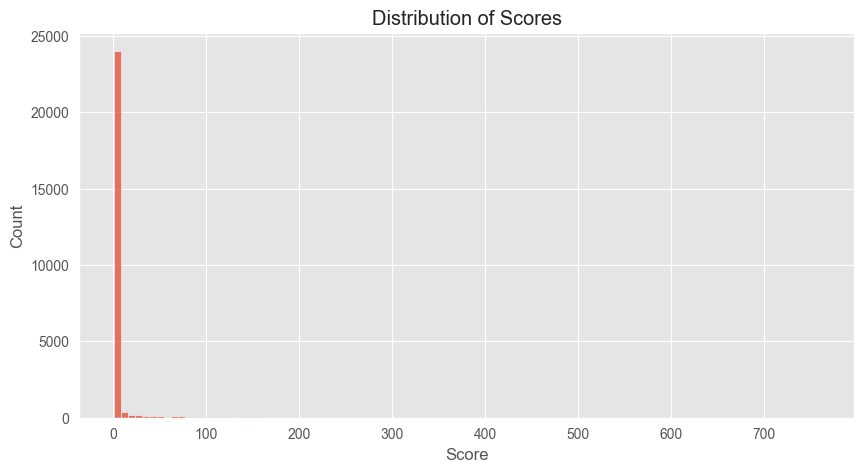

In [5]:
plt.figure(figsize=(10, 5))
sns.histplot(df['score'], bins=100, kde=False)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()


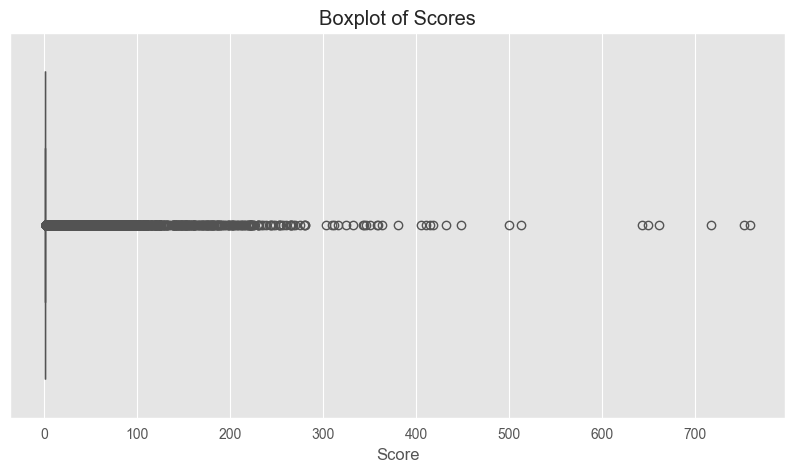

In [6]:
# Boxplot to identify outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['score'])
plt.title('Boxplot of Scores')
plt.xlabel('Score')
plt.show()

The top 10 movies with the highest outlier scores include titles such as "Shrek 2", "Despicable Me", "Despicable Me 2", "The Sea Beast", "The Angry Birds Movie 2", and "Red Notice". The scores for these movies range from 432 to 759, which are significantly higher than the typical scores in the dataset. These movies span release years from 2004 to 2022 and have runtimes from 93 to 117 minutes.

These movies are from various countries, including Mexico, the United States, Denmark, India, Norway, Singapore, Chile, Austria, and Thailand. 

## Mexico

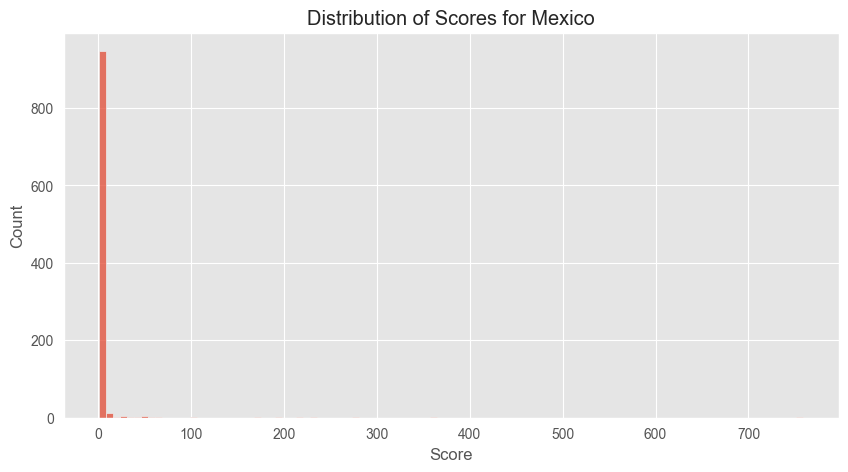

In [7]:
# Filter the DataFrame for entries from Mexico
mexico_df = df[df['country'] == 'Mexico']

# Plot distribution of the 'score' column for Mexico
plt.figure(figsize=(10, 5))
sns.histplot(mexico_df['score'], bins=100, kde=False)
plt.title('Distribution of Scores for Mexico')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

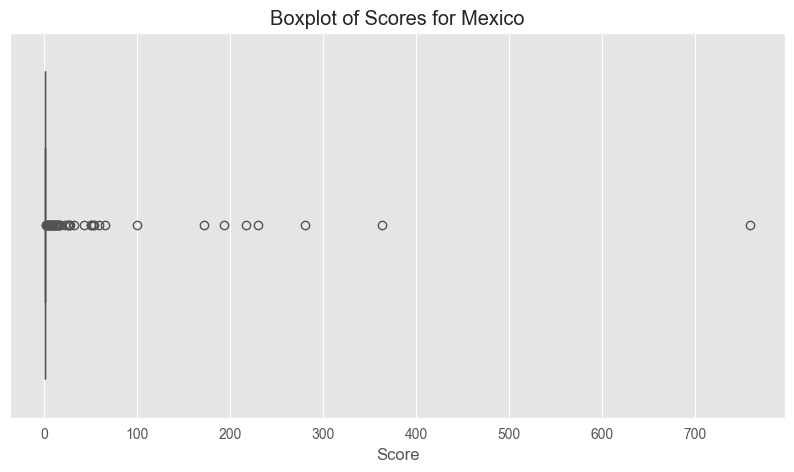

In [8]:
# Boxplot to identify outliers in Mexico's scores
plt.figure(figsize=(10, 5))
sns.boxplot(x=mexico_df['score'])
plt.title('Boxplot of Scores for Mexico')
plt.xlabel('Score')
plt.show()

For Mexico, the distribution of scores is similar to the overall dataset with a large concentration of scores at the lower end and a few extreme outliers. The mean score is approximately 4.09, but the standard deviation is quite high at 31.55 due to these outliers.

The maximum score observed is 759 for "Shrek 2", which is a significant outlier. Other movies with high outlier scores include "Wonder", "Vivo", "Matilda", and "American Assassin", with scores ranging from 217 to 363.

These results indicate that the presence of outliers is not just a global phenomenon but also evident within the subset of Mexican movie scores.

## Brazil

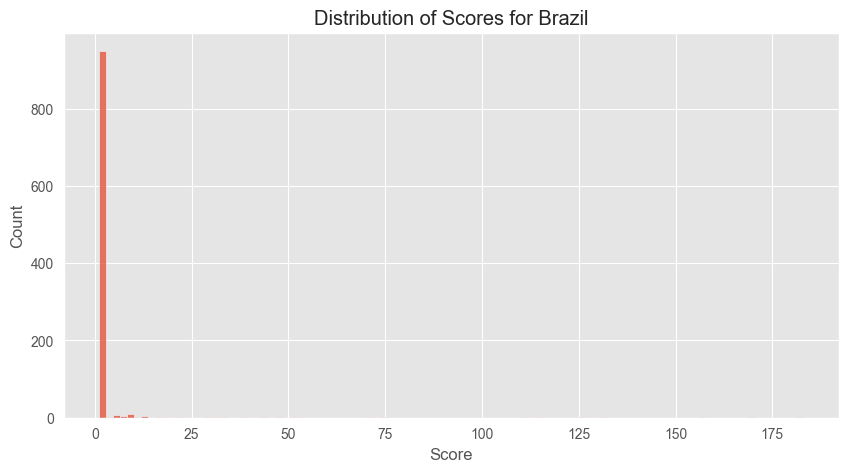

In [9]:
# Filter the DataFrame for entries from Brazil
brazil_df = df[df['country'] == 'Brazil']

# Plot distribution of the 'score' column for Brazil
plt.figure(figsize=(10, 5))
sns.histplot(brazil_df['score'], bins=100, kde=False)
plt.title('Distribution of Scores for Brazil')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

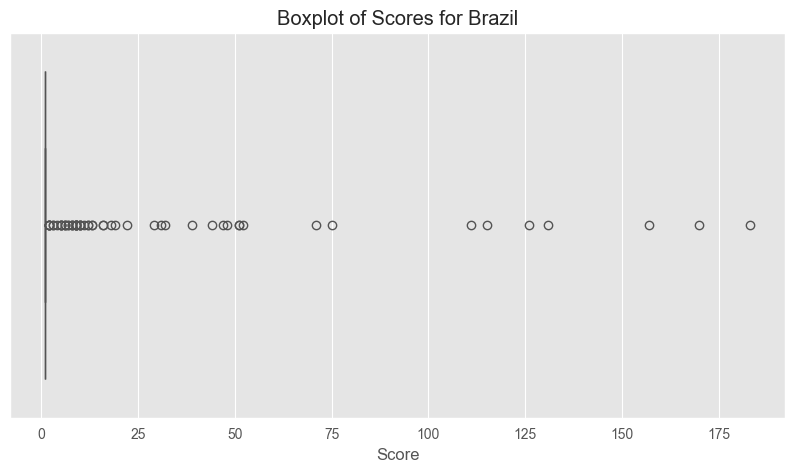

In [10]:
# Boxplot to identify outliers in Brazil's scores
plt.figure(figsize=(10, 5))
sns.boxplot(x=brazil_df['score'])
plt.title('Boxplot of Scores for Brazil')
plt.xlabel('Score')
plt.show()

For Brazil, the distribution of scores shows that most movies have low scores, similar to the pattern observed for Mexico and the overall dataset, with a concentration of scores at the lower end of the scale. 

The maximum score in the dataset for Brazil is 183 for "The Royal Treatment". Other high-scoring movies include "Tall Girl 2" with a score of 170, "Vivo" with a score of 157, "Home Team" with a score of 131, "Marmaduke" with a score of 126, and "Jack Reacher" with a score of 115.

These scores indicate that these movies had multiple top 10 appearances during their run in Brazil, contributing to their high cumulative scores. 

## USA

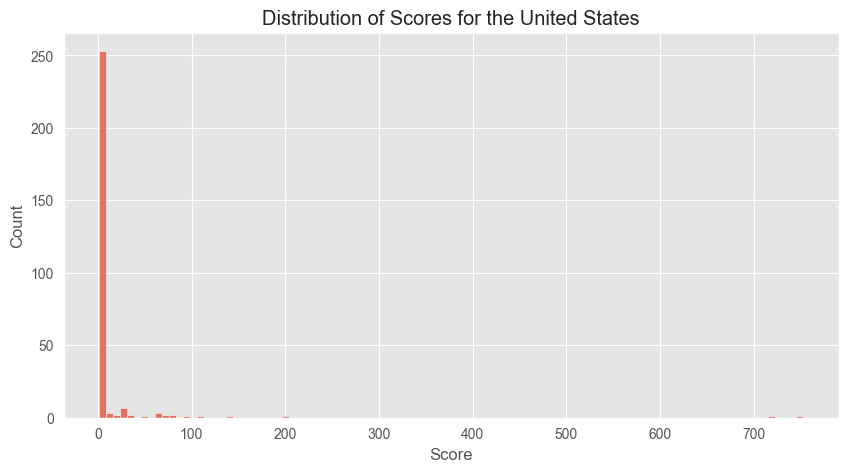

In [11]:
# Filter the DataFrame for entries from the United States
us_df = df[df['country'] == 'United States']

# Plot distribution of the 'score' column for the United States
plt.figure(figsize=(10, 5))
sns.histplot(us_df['score'], bins=100, kde=False)
plt.title('Distribution of Scores for the United States')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

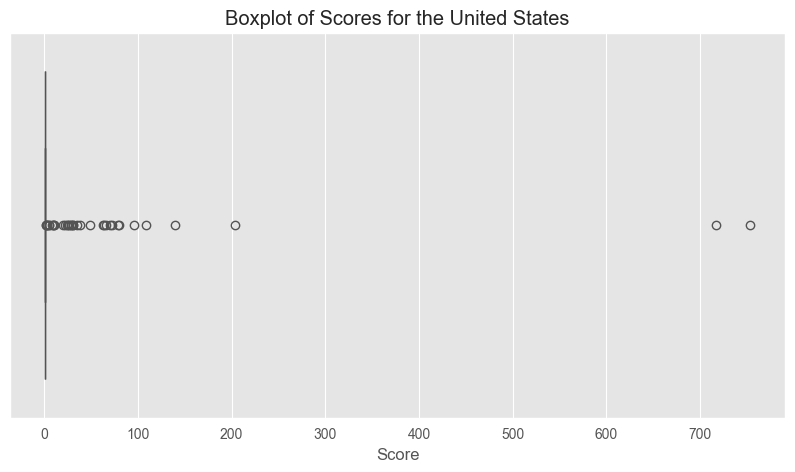

In [12]:
# Boxplot to identify outliers in the United States' scores
plt.figure(figsize=(10, 5))
sns.boxplot(x=us_df['score'])
plt.title('Boxplot of Scores for the United States')
plt.xlabel('Score')
plt.show()

For the United States, the scores also display a concentration at the lower end of the scale, indicating that most movies do not frequently appear in the top 10, hence receiving the minimum score of 1.

The mean score for movies in the United States is about 11.30, with a significant standard deviation of 64.77 due to outliers. The maximum score is 753 for "Despicable Me", with "Despicable Me 2" also having a very high score of 717.

These scores suggest that "Despicable Me" and "Despicable Me 2" had numerous appearances in the top 10 rankings over their run in the United States, leading to their high cumulative scores. The pattern is consistent with a scoring system based on daily rankings within the top 10, where a high cumulative score indicates sustained popularity.

# Analysis for originals vs non-originals

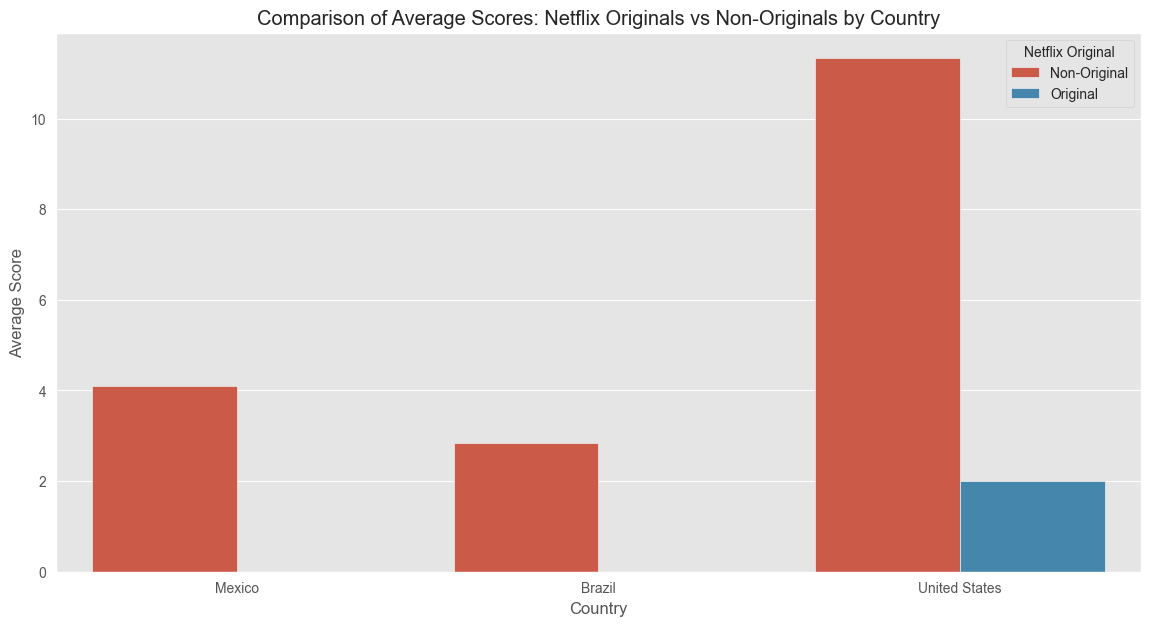

In [13]:
# Compare originals vs non-originals by country
mexico_originals_comparison = compare_originals_by_country(df, 'Mexico')
brazil_originals_comparison = compare_originals_by_country(df, 'Brazil')
us_originals_comparison = compare_originals_by_country(df, 'United States')

plt.figure(figsize=(14, 7))
sns.barplot(x='Country', y='Average Score', hue='Netflix Original', data=pd.concat([mexico_originals_comparison, brazil_originals_comparison, us_originals_comparison], ignore_index=True))
plt.title('Comparison of Average Scores: Netflix Originals vs Non-Originals by Country')
plt.ylabel('Average Score')
plt.xlabel('Country')
plt.legend(title='Netflix Original')
plt.show()

# Analysis for performance across countries

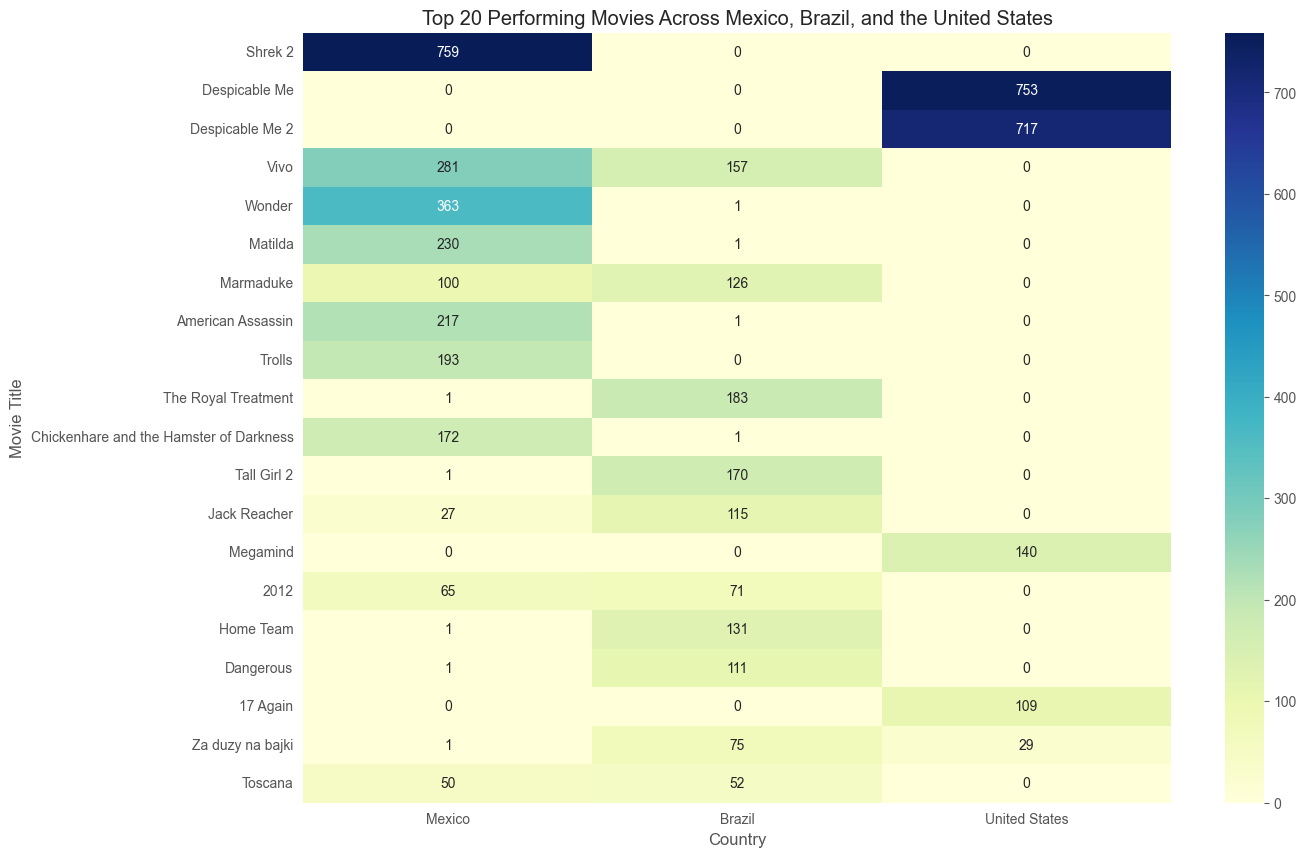

In [14]:
movie_country_counts = df.groupby('jw_entity_id')['country'].nunique().reset_index()
multi_country_movies = movie_country_counts[movie_country_counts['country'] > 1]['jw_entity_id']
multi_country_scores = df[df['jw_entity_id'].isin(multi_country_movies)].pivot_table(index='original_title', columns='country', values='score', aggfunc='sum', fill_value=0)
countries_of_interest = ['Mexico', 'Brazil', 'United States']
multi_country_scores = multi_country_scores[countries_of_interest]
multi_country_scores['Total Score'] = multi_country_scores.sum(axis=1)
multi_country_scores_sorted = multi_country_scores.sort_values(by='Total Score', ascending=False)
top_multi_country_scores = multi_country_scores_sorted.head(20).drop('Total Score', axis=1)

# Compare top 20 performing movies across countries
plt.figure(figsize=(14, 10))
sns.heatmap(top_multi_country_scores, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('Top 20 Performing Movies Across Mexico, Brazil, and the United States')
plt.ylabel('Movie Title')
plt.xlabel('Country')
plt.show()

# Distribution fitting
The best-fitting distribution for the non-zero, distinct scores in Mexico, according to the sum of squared estimate of errors (SSE), appears to be the log-normal distribution. This suggests that the scores in Mexico, as an ordered statistic, might be well-modeled by a log-normal distribution

This makes intuitive sense as well, given that log-normal distributions are often used to model the distribution of movie success metrics, which typically have a right-skewed distribution where most movies achieve a small degree of success but a few achieve tremendous success.

In [15]:
# We will consider the non-zero, distinct scores again
distinct_scores = mexico_df['score'].loc[mexico_df['score'] > 1].unique()

# List of distributions to check
distributions = [stats.expon, stats.lognorm, stats.norm, stats.weibull_min, stats.gamma]

# Store the results
dist_results = []
for distribution in distributions:
    # Fit distribution to data
    params = distribution.fit(distinct_scores)
    
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    
    # Calculate fitted PDF and error with fit in distribution
    pdf_values = [distribution.pdf(dist_score, loc=loc, scale=scale, *arg) for dist_score in distinct_scores]
    # Calculate SSE (sum of squared estimate of errors)
    sse = np.sum(np.power(distinct_scores - pdf_values, 2.0))
    
    # Append distribution and sse to results
    dist_results.append((distribution.name, sse))

# Sort results by sse
best_fit = sorted(dist_results, key=lambda x: x[1])
best_fit[0]  # Display the best fit distribution

('lognorm', 987105.0906490581)

The log-normal distribution is a continuous probability distribution of a random variable whose logarithm is normally distributed. This implies that if $Y$ is a normally distributed variable, then $e^Y$ is log-normally distributed. The distribution is defined by two parameters:

- **μ (mu)**: The mean of the logarithm of the variable, which represents the mean of the underlying normal distribution of the logarithm of the variable, not the mean of the log-normal distribution itself.
- **σ (sigma)**: The standard deviation of the logarithm of the variable, which is the standard deviation of the underlying normal distribution of the logarithm of the variable, not the log-normal distribution.

Key properties of the log-normal distribution include:

1. **Skewness**: The log-normal distribution is right-skewed, with a long tail extending to the right, which is typical in many real-world scenarios where a variable is constrained to be positive.

2. **Multiplicative Processes**: The log-normal distribution often arises in processes where a variable is subjected to multiple factors that have multiplicative effects.

3. **Non-Negativity**: It is defined only for positive values, which suits many real-life quantities that cannot be negative, such as lengths, sizes, and prices.

4. **Mode, Median, Mean**: In a log-normal distribution, the mode is less than the median, which is less than the mean. These inequalities characterize the skewness of the distribution. Specifically, for a log-normal distribution, the median is $e^\mu $, and the mean is $e^{\mu + \frac{\sigma^2}{2}}$.

5. **Variability**: The variance of a log-normal distribution is dependent on both μ and σ, and the variance increases significantly with σ due to the exponential transformation.

The log-normal distribution is well-suited to describe distributions where the majority of observations are clustered around a lower value, with relatively few large values — a common pattern in real-world phenomena where growth and multiplicative processes are present.

## Histogram of the Mexico scores and PDF of the log-normal distribution.
The histogram represents the actual distribution of distinct, non-zero scores. The red line is the probability density function (PDF) of the log-normal distribution fitted to the data.

The fit appears to capture the overall trend of the data well, with the peak of the fitted distribution aligning with the most common values of the scores. This visual representation supports the earlier statistical test suggesting that the log-normal distribution is a good model for the ordered scores of movies in Mexico.

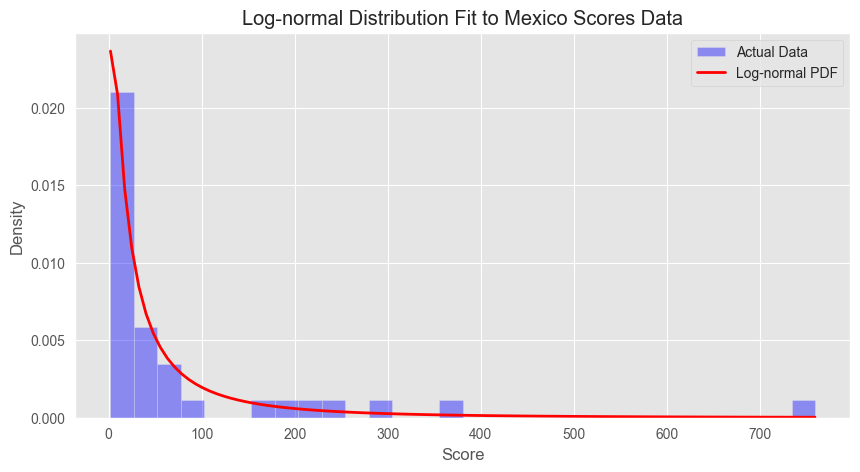

In [16]:
# Parameters for the log-normal distribution from the previous fit
shape, loc, scale = stats.lognorm.fit(distinct_scores, floc=0)

# Create a range of values for x (scores) to plot the PDF
xmin, xmax = min(distinct_scores), max(distinct_scores)
x_values = np.linspace(xmin, xmax, 100)

# Calculate the PDF of the log-normal distribution with the fitted parameters
pdf_values = stats.lognorm.pdf(x_values, shape, loc=loc, scale=scale)

# Plot histogram of the actual scores
plt.figure(figsize=(10, 5))
sns.distplot(distinct_scores, bins=30, kde=False, norm_hist=True, color='blue', label='Actual Data')

# Plot the PDF of the log-normal distribution
plt.plot(x_values, pdf_values, 'r-', lw=2, label='Log-normal PDF')

plt.title('Log-normal Distribution Fit to Mexico Scores Data')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()


## Brazil

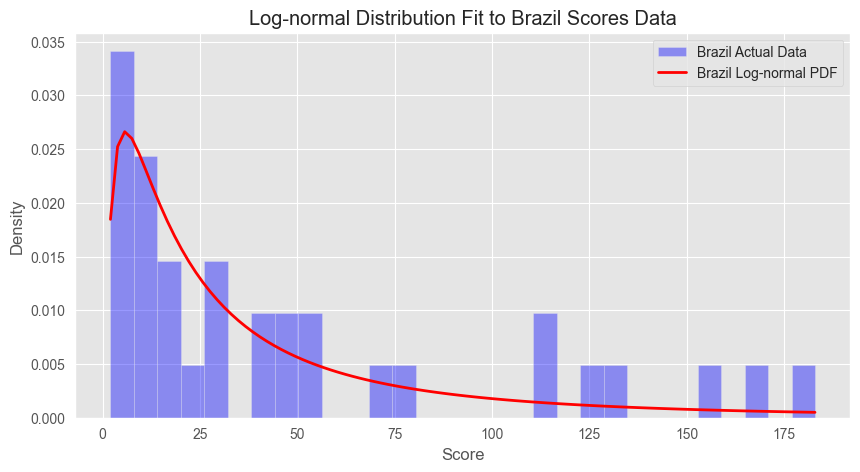

In [17]:
# Fit the log-normal distribution to the distinct scores for Brazil
brazil_distinct_scores = brazil_df['score'].loc[brazil_df['score'] > 1].unique()
brazil_params = stats.lognorm.fit(brazil_distinct_scores, floc=0)
brazil_xmin, brazil_xmax = min(brazil_distinct_scores), max(brazil_distinct_scores)
brazil_x_values = np.linspace(brazil_xmin, brazil_xmax, 100)
brazil_pdf_values = stats.lognorm.pdf(brazil_x_values, brazil_params[0], loc=brazil_params[1], scale=brazil_params[2])

# Fit the log-normal distribution to the distinct scores for the United States
us_distinct_scores = us_df['score'].loc[us_df['score'] > 1].unique()
us_params = stats.lognorm.fit(us_distinct_scores, floc=0)
us_xmin, us_xmax = min(us_distinct_scores), max(us_distinct_scores)
us_x_values = np.linspace(us_xmin, us_xmax, 100)
us_pdf_values = stats.lognorm.pdf(us_x_values, us_params[0], loc=us_params[1], scale=us_params[2])

# Plot histogram and log-normal PDF for Brazil
plt.figure(figsize=(10, 5))
sns.distplot(brazil_distinct_scores, bins=30, kde=False, norm_hist=True, color='blue', label='Brazil Actual Data')
plt.plot(brazil_x_values, brazil_pdf_values, 'r-', lw=2, label='Brazil Log-normal PDF')
plt.title('Log-normal Distribution Fit to Brazil Scores Data')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()

## USA

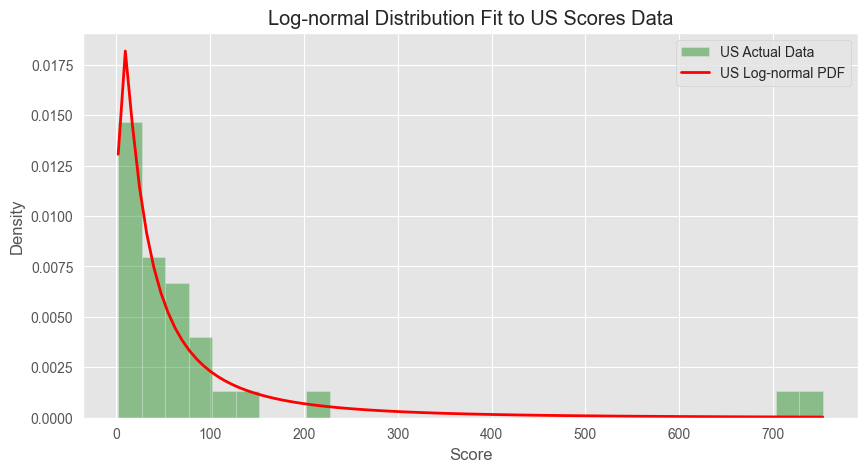

In [18]:
# Plot histogram and log-normal PDF for the United States
plt.figure(figsize=(10, 5))
sns.distplot(us_distinct_scores, bins=30, kde=False, norm_hist=True, color='green', label='US Actual Data')
plt.plot(us_x_values, us_pdf_values, 'r-', lw=2, label='US Log-normal PDF')
plt.title('Log-normal Distribution Fit to US Scores Data')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()

The visualizations above show the log-normal distribution fitted to the distinct, non-zero scores for Brazil (in blue) and the United States (in green). In both cases, the red line represents the probability density function (PDF) of the log-normal distribution with parameters estimated from the data.

These visual fits suggest that the log-normal distribution also models the distribution of movie scores for Brazil and the United States well, with the peak of the PDF aligning with the most common values in the actual data. The skewness of the log-normal distribution captures the right-tailed nature of the score distributions in both countries, consistent with the earlier analysis for Mexico.

,person_id,original_release_year,tenure,score,talent_total_score,talent_average_score,talent_max_score,talent_min_score,talent_median_score,talent_std_score,talent_count,talent_total_role_score,talent_average_role_score,talent_total_genre_role_score,talent_average_genre_role_score
count,3.553100e+04,35531.000000,35531.000000,35531.000000,35531.000000,35531.000000,35531.000000,35531.000000,35531.000000,13091.000000,35531.000000,35531.000000,35531.000000,35529.000000,35529.000000
mean,4.060056e+05,2010.983704,13.480876,5.212828,10.250514,5.212828,8.119473,3.733163,4.557035,6.484815,1.952464,8.578312,5.212828,5.837457,5.213065
std,6.126781e+05,10.168661,13.639378,36.345215,62.417436,31.388121,49.324770,27.820666,30.481106,36.637569,2.104922,49.685091,31.880453,38.654306,35.398992
min,1.600000e+01,1953.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.460650e+04,2005.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,7.247300e+04,2013.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,6.367345e+05,2019.000000,21.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,2.000000,1.000000,1.000000,1.000000
max,2.451550e+06,2022.000000,89.000000,759.000000,2277.000000,759.000000,759.000000,759.000000,759.000000,535.986940,29.000000,955.000000,759.000000,760.000000,759.000000
